## 依赖

In [1]:
import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

preprocess_path = "./input/"
classes_num = 2
img_height = 299
img_width = 299

Using TensorFlow backend.
/home/andrew1993/anaconda2/envs/breastc/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andrew1993/anaconda2/envs/breastc/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andrew1993/anaconda2/envs/breastc/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

## 均衡样本

In [2]:
import random
tumor_files = glob(os.path.join(preprocess_path,"tumor/*jpg"))
normal_files = np.random.choice(glob(os.path.join(preprocess_path, "normal/*jpg")),len(tumor_files))
train_files = list(tumor_files) + list(normal_files)
random.shuffle(train_files)


## 数据增强

In [3]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip with probability 0.5
    
        iaa.Affine(
            scale=(1, 1.1),
            rotate=90*np.random.choice([1,2,3]), # rotate by -180 to +180 degrees
        ),
    ],
    random_order=True
)

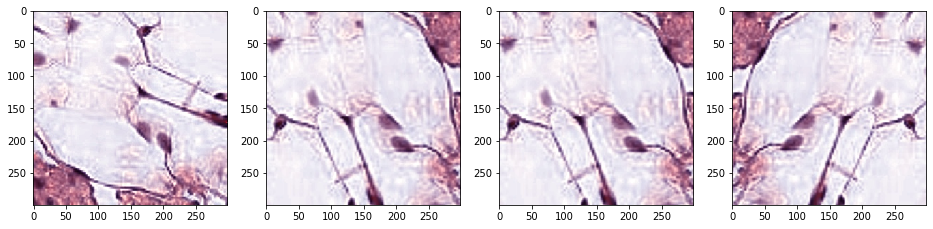

In [4]:
def show_augmented_images(img_file):
    img = cv2.imread(img_file)
    imgs = [img] + seq.augment_images([img for x in range(4)])

    plt.figure(figsize=(16, 6))
    for i in range(0, 4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[i])
        
show_augmented_images(train_files[0])
#show_augmented_images(train_files[1])
#show_augmented_images(train_files[2])
#show_augmented_images(train_files[3])

In [5]:
#tumor 1 normal 0
def get_level(path):
    if(path.split('/')[2]=='tumor'):
        return 1
    elif(path.split('/')[2]=='normal'):
        return 0
    else:
        print('1')
        return None
    


# Example: 1 -> [0, 1]
def get_onehot(level):
    level_vec = np.zeros(classes_num)
    level_vec[level] = 1
    
    return level_vec

In [6]:
from keras.utils.data_utils import Sequence

class DataSequence(Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))
                #class_weights = get_class_weights(current_epoch)

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

## 网络结构

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

img_channels = 3
img_dim = (img_height, img_width, img_channels)
from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'Inceptin_{}'.format(time_str)

    return experiment_id
def inceptionv3(img_dim=img_dim):
    input_tensor = Input(shape=img_dim)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=img_dim)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(classes_num, activation='softmax')(x)
    model = Model(input_tensor, output)
    return model

model = inceptionv3()
model.summary()

In [ ]:
from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'Inceptin_{}'.format(time_str)

## 训练集测试集划分

In [12]:
n_val_files = len(train_files) // 10
val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

## 训练过程

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
batch_size = 16

train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)
#use multigpu 8
#model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])
#parallel_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])
experiment_id = get_experiment_id()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint("inceptionV3_sgd"+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=(len(train_gen)//10),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              epochs=50,
                              callbacks=callbacks,
                              workers=12, # recommend: number of cpu cores
                              use_multiprocessing=False)

# Run the model directly

In [7]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
from keras.models import load_model

In [9]:
model = load_model(
    './inceptionV3_sgd.hdf5')

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,894
Trainable params: 21,772,456
Non-trainable params: 34,438
__________________________________________

## 预测测试集

In [12]:
n_val_files = len(train_files) // 10
val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

In [14]:
batch_size = 16
train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)

In [15]:
y_pred = model.predict_generator(validate_gen, len(validate_gen),verbose=1,workers=20)
y_pred = np.argmax(y_pred, axis=1)

1113/1113 [==============================] - 78s 70ms/step


In [17]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

y_true = flatten_list([np.argmax(y_true, axis=1) for x, y_true in validate_gen])

In [18]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

confusion_table = confusion_matrix(y_true, y_pred)
confusion_table

array([[8097,  753],
       [ 649, 8309]])

## 混淆矩阵

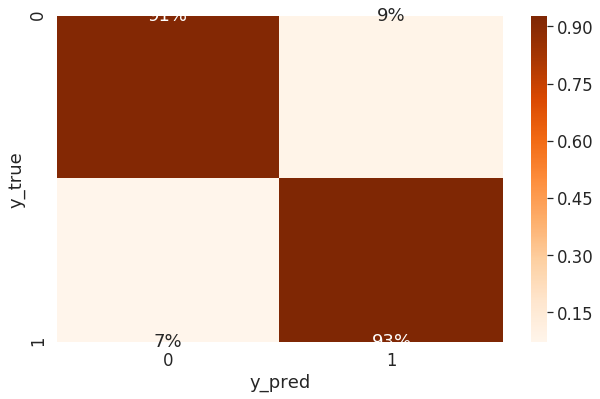

In [19]:
y_p=[]
y_t=[]
for var in (y_pred):
    if var>0:
        y_p.append(1)
    else:
        y_p.append(0)
for var in (y_true):
    if var>0:
        y_t.append(1)
    else:
        y_t.append(0)
c_table = confusion_matrix(y_t, y_p)
normalized_cf_matrix= c_table / c_table.sum(axis=1, keepdims=True)
df_cmx = pd.DataFrame(normalized_cf_matrix, index=[0, 1], columns=[0, 1])
plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='.0%')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

In [20]:
correct = 0
for i in range(len(y_pred)):
    if y_pred[i]==y_true[i]:
        correct +=1
print(correct/len(y_pred))

0.9212713387241689
